In [40]:
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

%matplotlib inline

In [4]:
url = 'http://mattmahoney.net/dc/'
last_percent_reported = None
data_root = '.'

def download_pregress_hook(count, blocksize, totalsize):
    global last_percent_reported
    percent = int(count*blocksize*100/totalsize)
    
    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()
    last_percent_reported = percent
    
def maybe_download(filename, expected_bytes, force=False):
    dest_filename = os.path.join(data_root,filename)
    if force or not os.path.exists(dest_filename):
        print('Attempting to download:', filename) 
        filename,_ = urlretrieve(url+filename, dest_filename, reporthook=download_pregress_hook)
        print('\nDownload Complete!')
    statinfo = os.stat(dest_filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', dest_filename)
    else:
        raise Exception(
          'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
    return dest_filename

filename = maybe_download('text8.zip', 31344016)

Found and verified .\text8.zip


In [6]:
def read_data(filename):
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data

words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


## Build the dictionary and replace rate words with UNK token

In [15]:
vocabulary_size = 50000

def build_dataset(words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    for word,_ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0
            unk_count = unk_count+1
        data.append(index)
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data,count,dictionary,reverse_dictionary

data,count,dictionary,reverse_dictionary = build_dataset(words)

print('Most common words [+UNK]', count[:5])
print('Sample data', data[:10])

del words # hint to reduce memory

Most common words [+UNK] [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]


In [16]:
len(data)

17005207

In [18]:
len(dictionary)

50000

## Function to generate a traning batch for the skip-gram model

In [25]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2*skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2*skip_window + 1
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index+1)%len(data)
    for i in range(batch_size // num_skips):
        target = skip_window # target label at the center of the buffer
        target_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in target_to_avoid:
                target = random.randint(0, span-1)
            target_to_avoid.append(target)
            batch[i*num_skips + j] = buffer[skip_window]
            labels[i*num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index+1) % len(data)
    return batch,labels

print('data:',[reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2,1), (4,2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips=%d and skip_window=%d:' % (num_skips,skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips=2 and skip_window=1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['as', 'anarchism', 'a', 'originated', 'as', 'term', 'of', 'a']

with num_skips=4 and skip_window=2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['term', 'anarchism', 'originated', 'a', 'as', 'term', 'of', 'originated']


## Train a skip-gram model

In [32]:
batch_size = 128
embedding_size = 128 # Dimention of the embedding vector
skip_window = 1 
num_skips = 2

valid_size = 16
valid_window = 100
valid_example = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size,1])
    valid_dataset = tf.constant(valid_example, dtype=tf.int32)
    
    # Variable
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size], stddev=1.0/math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
    
    # Model:
    # Look up embedding for inputs
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(weights=softmax_weights,biases=softmax_biases, inputs=embed, 
                                                     labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))
    
    #Optimizer
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
    
    # Compute the similarity between minibatch and all embeddings
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embedding = embeddings/norm
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
    similary = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))

In [35]:
embeddings

<tf.Variable 'Variable:0' shape=(50000, 128) dtype=float32_ref>

In [36]:
num_steps = 100001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_data, batch_label = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_dataset:batch_data, train_labels:batch_label}
        _,l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % 2000 == 0:
            if step>0:
                average_loss = average_loss / 2000
            print('Average loss at step %d: %f' %(step, average_loss))
            average_loss = 0
        if step % 10000 == 0:
            sim = similary.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_example[i]]
                top_k = 8
#                 print(sim)
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embedding.eval()

Initialized
Average loss at step 0: 7.061128
Nearest to not: handedly, administer, kames, predominantly, fugitives, interactive, pentagons, holiness,
Nearest to eight: dimona, logarithm, remade, ghali, ejaculate, intermediary, sparring, miranda,
Nearest to see: unnamed, amateurs, wrapped, consult, edges, recommend, strait, bretton,
Nearest to nine: skirmish, hertogenbosch, misfits, briggs, bernstein, extremist, lacan, operatives,
Nearest to used: brisbane, connects, doings, abolished, interstitial, deeply, walks, cassino,
Nearest to are: bbbb, deontological, kilkenny, cloister, sectional, psychotherapy, abdication, gimmicks,
Nearest to a: preponderance, pickles, kvass, pity, stimulated, naismith, permittivity, mods,
Nearest to between: retainers, symmes, hotels, unipolar, absorbing, flotilla, bde, desilu,
Nearest to world: blunder, sombart, biome, spacious, nd, dumpling, pebbles, styles,
Nearest to use: currency, pau, australians, betrothal, rden, financially, employees, pds,
Nearest t

Average loss at step 52000: 3.402381
Average loss at step 54000: 3.406152
Average loss at step 56000: 3.331169
Average loss at step 58000: 3.398818
Average loss at step 60000: 3.428746
Nearest to not: still, usually, generally, often, you, it, almost, now,
Nearest to eight: nine, six, seven, four, five, three, zero, one,
Nearest to see: includes, tirpitz, include, references, zadok, list, determinate, mas,
Nearest to nine: eight, seven, four, six, five, three, zero, one,
Nearest to used: known, considered, referred, seen, available, written, found, described,
Nearest to are: were, is, include, have, although, while, these, including,
Nearest to a: the, another, this, any, uncollected, emigrant, pastor, every,
Nearest to between: among, with, in, koans, from, whipping, through, within,
Nearest to world: variant, title, attain, badges, yan, escaped, promo, investiture,
Nearest to use: form, need, way, chorus, feature, izz, cause, voice,
Nearest to their: its, his, her, the, our, sandhi, 

In [37]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1,:])
two_d_embeddings

array([[ -1.30667791e+01,   3.55291138e+01],
       [ -4.61016083e+01,   4.14748716e+00],
       [ -5.06604462e+01,   7.74169397e+00],
       [  3.81078491e+01,   4.04685364e+01],
       [ -4.75462646e+01,  -9.42486191e+00],
       [ -1.43035908e+01,   3.16777401e+01],
       [ -3.24663734e+01,   4.66746521e+01],
       [  3.70549164e+01,   3.15702667e+01],
       [  4.15485344e+01,   3.40516090e+01],
       [  3.52551346e+01,   3.85327950e+01],
       [ -2.36153755e+01,   2.00790462e+01],
       [ -4.00244217e+01,   4.24808979e+00],
       [  3.96964493e+01,   3.50495796e+01],
       [ -4.27658386e+01,   4.54728752e-02],
       [ -1.08714981e+01,   4.62936096e+01],
       [  3.73545189e+01,   3.43333397e+01],
       [  3.50811195e+01,   3.55797348e+01],
       [ -2.40693722e+01,   2.18682232e+01],
       [ -4.43958778e+01,  -3.77964354e+00],
       [  8.85288048e+00,   2.70477314e+01],
       [  3.69556885e+01,   3.64365311e+01],
       [  3.86841736e+01,   3.74436569e+01],
       [  

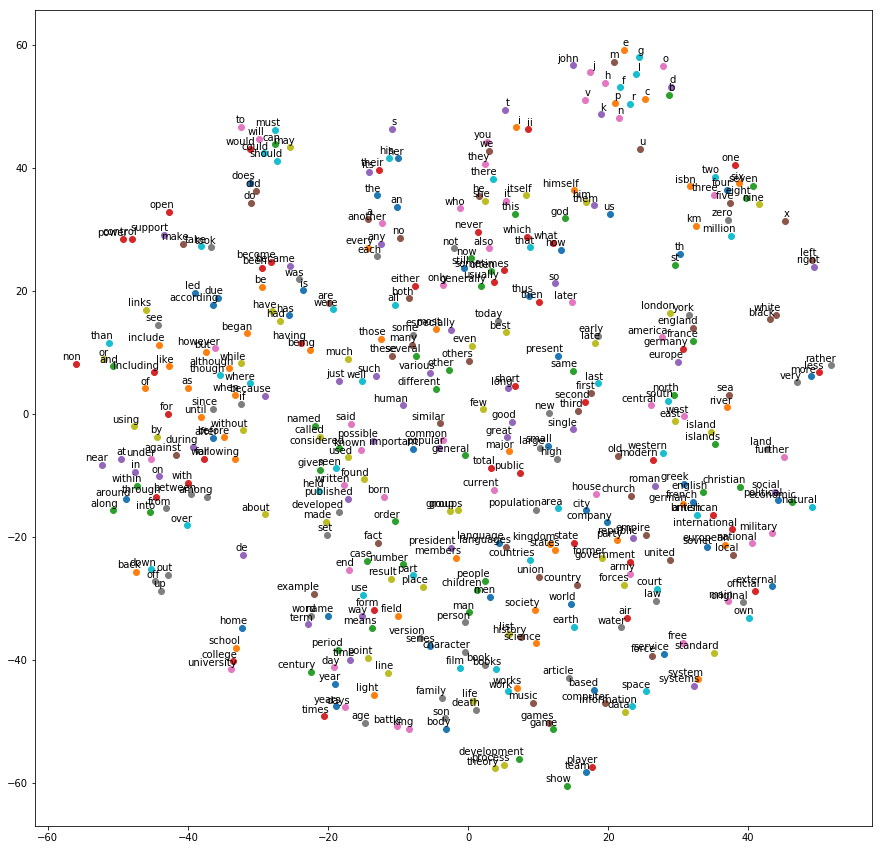

In [42]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15)) # in inches
    for i, label in enumerate(labels):
        x,y = embeddings[i,:]
        pylab.scatter(x,y)
        pylab.annotate(label, xy=(x,y), xytext=(5,2),textcoords='offset points', ha='right', va='bottom')
    pylab.show()

words = [reverse_dictionary[i] for i in range(1,num_points+1)]
plot(two_d_embeddings, words)